In [45]:
# Mounting Google Drive
# Adding error handling when running Colab notebook locally
# Adding cell notebook when ran locally on a machine with 32 GB of RAM and i9 Processor
# If running, run as standard Colab file please provide path to file in the try block
try:
    from google.colab import drive
    drive.mount('/content/drive')
    filepath = "/content/drive/Othercomputers/My Laptop/diabetes_readmission/"
    msg = "Using Google Colab runtime, connection and resources"
except ModuleNotFoundError:
    filepath = 'C:\\Users\\micha\\Documents\\GitHub\\diabetes_readmission\\'
    msg = "Using local machine runtime, connection and resources"

print(msg)
filename = 'diabetes.csv'    
filepathname = filepath + filename

Using local machine runtime, connection and resources


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [47]:
plt.style.use('seaborn-deep')

In [48]:
df = pd.read_csv(filepathname, header=0, index_col = 'encounter_id')
df.head(1)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


# Problem Statement: Classify Encounters into readmitted  <30 (<=30), >30 and NO. This project is going to model the classification of patient readmissions into the following three classes:
*   Within 30 days (30th day inclusive) "<30" or "(<=30)"
*   From 31 days ">30"
*   Not readmitted "NO"

All encounters have a diagnosis of diabetes which is based on the clinical analysis of the patient's HbA1c or A1C test.

The American Diabetes Association (ADA) considers this relatively simple blood test a POWERHOUSE!! Some key bullets from their website: [ADA/A1C](https://diabetes.org/a1c)
* The test provides a picture of a person's blood sugar level over two to three months.
* The higher the levels, the greater a person's risk of developing diabetes complications.
* It can identify prediabetes, which raises the risk of diabetes.
* It can be used to diagnose diabetes.
* And, it's used to monitor how well the diabetes treatment is working over time.

The A1C feature in our dataset is very important, but it not enough by itself to help classify encounters into readmitted classes.

Throughout this project, I will continuously revisit this Problem Statement to ensure the model developed is built to help solve it.


# Start of Section on Functions

In [50]:
# Helper function that will show normalized value counts for features
def show_column_values():
    for feature in df.columns:
        print("Name of Feature:", feature)
        print(df[feature].value_counts(normalize=True))
        print("\n")

In [51]:
# Helper function to generate specific univariate plots
def create_plots(myXaxis,myYaxis,myXlabel,myYlabel,myTitle,myPlot,fsize=7):
    
    fig, notch_ax = plt.subplots(1, 1, figsize = (fsize,fsize))
    if myPlot == "Boxplot":
        sns.boxplot(ax = notch_ax,x = myXaxis, y = myYaxis, data = df,notch=True)
    elif myPlot == "Barplot":
        df_sub = df.groupby([myXaxis],as_index=False)[[myYaxis]].count()
        sns.barplot(ax = notch_ax, data = df_sub, x = myXaxis, y = myYaxis,edgecolor='black')
    elif myPlot == "Heatmap":
        sns.heatmap(ax = notch_ax, data=df.corr(),annot=True)
    elif myPlot == "Histplot":
        sns.histplot(data=df, x = myXaxis,bins=10)

    plt.title(myTitle)
    plt.xlabel(myXlabel)
    plt.ylabel(myYlabel)

    # Heatmap does not need to have y axis label formatted
    if myPlot != "Heatmap":
        plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()

# Start of Part 2 Requirements




In [52]:
df.shape

(101766, 49)

In [53]:
df.nunique()

patient_nbr                 71518
race                            6
gender                          3
age                            10
weight                         10
admission_type_id               8
discharge_disposition_id       26
admission_source_id            17
time_in_hospital               14
payer_code                     18
medical_specialty              73
num_lab_procedures            118
num_procedures                  7
num_medications                75
number_outpatient              39
number_emergency               33
number_inpatient               21
diag_1                        717
diag_2                        749
diag_3                        790
number_diagnoses               16
max_glu_serum                   4
A1Cresult                       4
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  4
glimepiride                     4
acetohexamide                   2
glipizide     

##Identify and delete unnecessary columns

In [54]:
# Inspect the columns that need to be dropped
show_column_values()

Name of Feature: patient_nbr
88785891     0.000393
43140906     0.000275
1660293      0.000226
88227540     0.000226
23199021     0.000226
               ...   
11005362     0.000010
98252496     0.000010
1019673      0.000010
13396320     0.000010
175429310    0.000010
Name: patient_nbr, Length: 71518, dtype: float64


Name of Feature: race
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64


Name of Feature: gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64


Name of Feature: age
[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: age, dtype: float64


Name of Feature: weight
?            0.968585
[75-100)     0.

This section attempts to explain the reasons for dropping some of the columns from the initial dataframe.
The reasons are:

After exploring the dataframe and reading the [Beata et al article](https://www.hindawi.com/journals/bmri/2014/781670/), and these four columns (weight, payer_code, medical_specialty and patient_nbr) are dropped:
1. weight: Over 97% of the records are missing the weight value
2. payer_code: Over 40% of the records are missing the payor code, payers don't make the decision on when to admit
3. medical_specialty: Over 49% of the records are missing the specialty value, specialty is not making the decision to admit. It is based on the clinical findings which are determined from the assessment of the health team
4. patient_nbr: not reliable enough to use and since it is an integer, the model might give higher patient_nbr a higher weight/value
5. The following columns are also dropped because they don't support variance explanation:
    * admission_type_id; values such as Emergency, Urgent, Elective, Newborn and Trauma Center won't help in classifying the readmitted target
    * admission_source_id; the 26 unique values won't help in classifying the readmitted target, grouping these values into clusters won't improve the model
6. The following columns are dropped because the numeric values assigned within each feature will not improve the classification model's performance, these features are more related to other diagnoses, which we account for in the number_diagnoses (co-morbidity) feature:
    * num_lab_procedures
    * num_procedures
    * num_medications
7. The following columns would make the model unnecessarily complex, the values reported are ICD9 (International Classification of Diseases and Procedures) codes used by hospitals to code diagnoses and procedures, including these columns as features would require significant pre-work to evaluate the ICD9 codes and convert these codes into values which represent some weight in terms of high-risk for readmission, a separate project on its own:
    * diag_1
    * diag_2
    * diag_3
8. All the medications listed as columns are also dropped except insulin.

In [55]:
features_included = ['race','gender','age','discharge_disposition_id',
                     'time_in_hospital','number_outpatient',
                     'number_emergency','number_inpatient',
                     'number_diagnoses','max_glu_serum','A1Cresult',
                     'insulin','change','diabetesMed','readmitted']

In [56]:
# Resetting dataframe df to columns to be used as features and target
# Columns not in the list features_included will be dropped
df = df[features_included]

In [57]:
df.shape # Dropped 44 columns

(101766, 15)

##Identify and delete rows with invalid or inappropriate values

This section attempts to explain the reasons and approaches to dropping rows with invalid values.
* Based on the [Beata et al article](https://www.hindawi.com/journals/bmri/2014/781670/), excluding records where the discharge disposition is expired or discharged to hospice, will eliminate bias.
* The approach taken by the authors is correct, it would be nonsensical to build the model with records of patients that have expired.
* One might ask why not have the model predict that these patients should be classified in the "NO" class.
* The problem with the statement above is that some in the "NO" class may neither be expired nor transferred to hospice.
* The model needs to learn well how to clarify the "NO" class without bias from records we know will not be readmitted at all.
* Within discharge disposition NULL (NaN), Not Mapped, Unknown/Invalid are also dropped.

In [58]:
dischargefile = filepath + "discharge_disposition.csv"
discharge_df = pd.read_csv(dischargefile)
discharge_df

,discharge_disposition_id,description,Cluster
0,1,Discharged to home,Home
1,2,Discharged/transferred to another short term h...,Care Facility
2,3,Discharged/transferred to SNF,Care Facility
3,4,Discharged/transferred to ICF,Care Facility
4,5,Discharged/transferred to another type of inpa...,Care Facility
5,6,Discharged/transferred to home with home healt...,Home
6,7,Left AMA,AMA
7,8,Discharged/transferred to home under care of H...,Home
8,9,Admitted as an inpatient to this hospital,Care Facility
9,10,Neonate discharged to another hospital for neo...,Care Facility


In [59]:
expired_discharge_df = discharge_df.loc[discharge_df['Cluster']=='Expired']
print(expired_discharge_df.shape)
expired_discharge_df

(9, 3)


,discharge_disposition_id,description,Cluster
10,11,Expired,Expired
12,13,Hospice / home,Expired
13,14,Hospice / medical facility,Expired
17,18,NaN,Expired
18,19,"Expired at home. Medicaid only, hospice.",Expired
19,20,"Expired in a medical facility. Medicaid only, ...",Expired
20,21,"Expired, place unknown. Medicaid only, hospice.",Expired
24,25,Not Mapped,Expired
25,26,Unknown/Invalid,Expired


In [60]:
# Dropping rows with discharge disposition of expired or discharged to hospice
num_rows = 0
missing_values = ['discharge_disposition_id']
for feature in missing_values:
    for id in [11,13,14,18,19,20,21,25,26]:
        df_filter = df[df[feature] == id]
        num_rows += df_filter.shape[0]
        print("Number of rows to be dropped: {:,.0f} with value of {} in feature {}".format(df_filter.shape[0],id,feature))
        df.drop(df_filter.index, inplace = True)
    print("Total number of rows deleted: {:,.0f}".format(num_rows))
    print("Number of rows in dataframe after rows are deleted: {:,.0f}\n".format(df.shape[0]))
    num_rows = 0


Number of rows to be dropped: 1,642 with value of 11 in feature discharge_disposition_id
Number of rows to be dropped: 399 with value of 13 in feature discharge_disposition_id
Number of rows to be dropped: 372 with value of 14 in feature discharge_disposition_id
Number of rows to be dropped: 3,691 with value of 18 in feature discharge_disposition_id
Number of rows to be dropped: 8 with value of 19 in feature discharge_disposition_id
Number of rows to be dropped: 2 with value of 20 in feature discharge_disposition_id
Number of rows to be dropped: 0 with value of 21 in feature discharge_disposition_id
Number of rows to be dropped: 989 with value of 25 in feature discharge_disposition_id
Number of rows to be dropped: 0 with value of 26 in feature discharge_disposition_id
Total number of rows deleted: 7,103
Number of rows in dataframe after rows are deleted: 94,663



The race and gender features contain rows with invalid values.
* race feature has about 2% of rows with a value of "?".
* It is appropriate to delete these rows.
* Instead of assuming the most frequent race would be the value appropriate
* gender feature also has rows with a value of "Unknown/Invalid".
* The count of rows is deemed statistical insignificant.
* And it is appropriate to delete.

In [61]:
# Dropping rows with inappropriate values
num_rows = 0
missing_values = ['race','gender']
for feature in missing_values:
    for id in ["?","Unknown/Invalid"]:
        df_filter = df[df[feature] == id]
        num_rows += df_filter.shape[0]
        print("Number of rows to be dropped: {:,.0f} with value of {} in feature {}".format(df_filter.shape[0],id,feature))
        df.drop(df_filter.index, inplace = True)
    print("Total number of rows deleted: {:,.0f}".format(num_rows))
    print("Number of rows in dataframe after rows are deleted: {:,.0f}\n".format(df.shape[0]))
    num_rows = 0

Number of rows to be dropped: 2,200 with value of ? in feature race
Number of rows to be dropped: 0 with value of Unknown/Invalid in feature race
Total number of rows deleted: 2,200
Number of rows in dataframe after rows are deleted: 92,463

Number of rows to be dropped: 0 with value of ? in feature gender
Number of rows to be dropped: 1 with value of Unknown/Invalid in feature gender
Total number of rows deleted: 1
Number of rows in dataframe after rows are deleted: 92,462



## Creating clusters for the following five features, all have integer values with over 20 unique values in each feature.
### Clustering and grouping will minimize the impact of outliers.
### Changing the values to categorical values would make the model inefficient.
### For the discharge_disposition, clusters have been identified based on the description of the value, see discharge_df above.
### For these four features below:
    * number_outpatient - number of outpatient visits of patient in the year preceding the encounter
    * number_emergency - number of emergency visits of patient in the year preceding the encounter
    * number_inpatient - number of inpatient visits(admissions) in the year preceding the encounter
    * number_diagnoses - number of diagnoses entered into the system
### Numeric values of 10 or greater than will be grouped under 10, more diagnoses or visits will not necessarily improve the classification performance of the model. These values are already high values for these kinds of features.

In [62]:
discharge_disposition_dict = dict()
for x in range(0,discharge_df.shape[0]):
    print(discharge_df.loc[x]['discharge_disposition_id'], discharge_df.loc[x]['Cluster'])
    discharge_disposition_dict.update({discharge_df.loc[x]['discharge_disposition_id']: discharge_df.loc[x]['Cluster']})

1 Home
2 Care Facility
3 Care Facility
4 Care Facility
5 Care Facility
6 Home
7 AMA
8 Home
9 Care Facility
10 Care Facility
11 Expired
12 Care Facility
13 Expired
14 Expired
15 Care Facility
16 Care Facility
17 Home
18 Expired
19 Expired
20 Expired
21 Expired
22 Care Facility
23 Care Facility
24 Care Facility
25 Expired
26 Expired
30 Care Facility
27 Care Facility
28 Care Facility
29 Care Facility


In [63]:
# Creating the discharge disposition groups
# Once groups are created, drop previous discharge disposition column
df['discharge_group'] = df['discharge_disposition_id'].map(discharge_disposition_dict)
df.drop(columns='discharge_disposition_id', inplace=True)

In [64]:
# Creating the clusters for visits and diagnoses features
# Once cluster is created drop previous field
df['num_of_outpatient'] = [10 if x >= 10 else x for x in df['number_outpatient']]
df.drop(columns='number_outpatient',inplace=True)

df['num_of_emergency'] = [10 if x >= 10 else x for x in df['number_emergency']]
df.drop(columns='number_emergency',inplace=True)

df['num_of_inpatient'] = [10 if x >= 10 else x for x in df['number_inpatient']]
df.drop(columns='number_inpatient',inplace=True)

df['num_of_diagnoses'] = [10 if x >= 10 else x for x in df['number_diagnoses']]
df.drop(columns='number_diagnoses',inplace=True)

In [65]:
# Inspect the features for rows that need to be deleted
# An imputer is not going to appropriate for this rows
show_column_values()

Name of Feature: race
Caucasian          0.767115
AfricanAmerican    0.190759
Hispanic           0.020354
Other              0.015174
Asian              0.006597
Name: race, dtype: float64


Name of Feature: gender
Female    0.539194
Male      0.460806
Name: gender, dtype: float64


Name of Feature: age
[70-80)     0.253369
[60-70)     0.221734
[50-60)     0.171692
[80-90)     0.166933
[40-50)     0.096267
[30-40)     0.038167
[90-100)    0.026346
[20-30)     0.016774
[10-20)     0.007106
[0-10)      0.001611
Name: age, dtype: float64


Name of Feature: time_in_hospital
3     0.176537
2     0.171779
1     0.140555
4     0.137873
5     0.097737
6     0.073511
7     0.056975
8     0.042309
9     0.028541
10    0.022279
11    0.017348
12    0.013584
13    0.011248
14    0.009723
Name: time_in_hospital, dtype: float64


Name of Feature: max_glu_serum
None    0.948660
Norm    0.025470
>200    0.013844
>300    0.012027
Name: max_glu_serum, dtype: float64


Name of Feature: A1Cresult
None    

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92462 entries, 149190 to 443867222
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   race               92462 non-null  object
 1   gender             92462 non-null  object
 2   age                92462 non-null  object
 3   time_in_hospital   92462 non-null  int64 
 4   max_glu_serum      92462 non-null  object
 5   A1Cresult          92462 non-null  object
 6   insulin            92462 non-null  object
 7   change             92462 non-null  object
 8   diabetesMed        92462 non-null  object
 9   readmitted         92462 non-null  object
 10  discharge_group    92462 non-null  object
 11  num_of_outpatient  92462 non-null  int64 
 12  num_of_emergency   92462 non-null  int64 
 13  num_of_inpatient   92462 non-null  int64 
 14  num_of_diagnoses   92462 non-null  int64 
dtypes: int64(5), object(10)
memory usage: 11.3+ MB


In [67]:
# Check for the existence of duplicate records
df.duplicated().sum()

25979

In [68]:
df.loc[df.duplicated(keep=False)]

,race,gender,age,time_in_hospital,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted,discharge_group,num_of_outpatient,num_of_emergency,num_of_inpatient,num_of_diagnoses
encounter_id,,,,,,,,,,,,,,,
16680,Caucasian,Male,[40-50),1,None,None,Steady,Ch,Yes,NO,Home,0,0,0,5
35754,Caucasian,Male,[50-60),3,None,None,Steady,No,Yes,>30,Home,0,0,0,9
55842,Caucasian,Male,[60-70),4,None,None,Steady,Ch,Yes,NO,Home,0,0,0,7
84222,Caucasian,Female,[50-60),3,None,None,No,No,Yes,NO,Home,0,0,0,3
182796,AfricanAmerican,Female,[70-80),2,None,None,No,No,No,NO,Home,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443824292,Caucasian,Female,[80-90),3,None,None,Down,Ch,Yes,<30,Home,0,0,0,9
443842016,Caucasian,Female,[70-80),9,None,>7,Steady,Ch,Yes,>30,Home,0,0,0,9
443842136,Caucasian,Female,[70-80),5,None,None,Steady,No,Yes,NO,Home,0,0,1,9


In [69]:
df.drop_duplicates(inplace=True)

In [70]:
show_column_values()

Name of Feature: race
Caucasian          0.720545
AfricanAmerican    0.222373
Hispanic           0.027496
Other              0.020592
Asian              0.008995
Name: race, dtype: float64


Name of Feature: gender
Female    0.543778
Male      0.456222
Name: gender, dtype: float64


Name of Feature: age
[70-80)     0.233744
[60-70)     0.210460
[50-60)     0.171773
[80-90)     0.164207
[40-50)     0.108720
[30-40)     0.047320
[90-100)    0.031542
[20-30)     0.021705
[10-20)     0.008754
[0-10)      0.001775
Name: age, dtype: float64


Name of Feature: time_in_hospital
3     0.164553
2     0.156611
4     0.135057
1     0.124964
5     0.100898
6     0.078336
7     0.063204
8     0.048584
9     0.034279
10    0.027315
11    0.021494
12    0.017418
13    0.014590
14    0.012695
Name: time_in_hospital, dtype: float64


Name of Feature: max_glu_serum
None    0.929907
Norm    0.034415
>200    0.019012
>300    0.016666
Name: max_glu_serum, dtype: float64


Name of Feature: A1Cresult
None    

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66483 entries, 149190 to 443857166
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   race               66483 non-null  object
 1   gender             66483 non-null  object
 2   age                66483 non-null  object
 3   time_in_hospital   66483 non-null  int64 
 4   max_glu_serum      66483 non-null  object
 5   A1Cresult          66483 non-null  object
 6   insulin            66483 non-null  object
 7   change             66483 non-null  object
 8   diabetesMed        66483 non-null  object
 9   readmitted         66483 non-null  object
 10  discharge_group    66483 non-null  object
 11  num_of_outpatient  66483 non-null  int64 
 12  num_of_emergency   66483 non-null  int64 
 13  num_of_inpatient   66483 non-null  int64 
 14  num_of_diagnoses   66483 non-null  int64 
dtypes: int64(5), object(10)
memory usage: 8.1+ MB


# Univariate Visualizations for features and Target (readmitted)

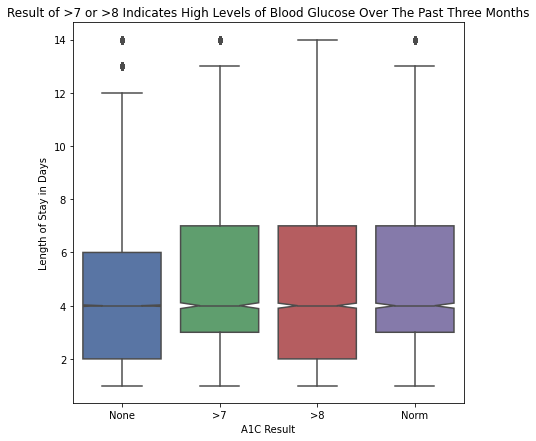

Patients with A1C greater than 7 are showing up in the higher
Length of Stay, higher A1C may require longer hospitalizations



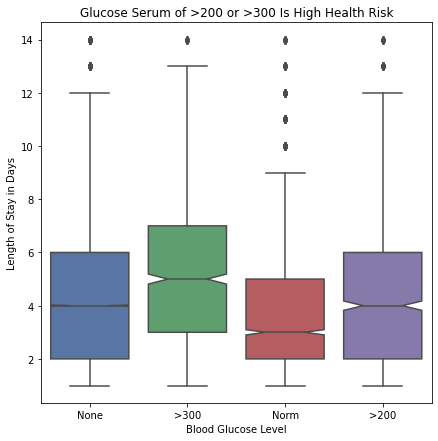

Patients with blood glucose higher than 200 are also showing higher
Length of Stay


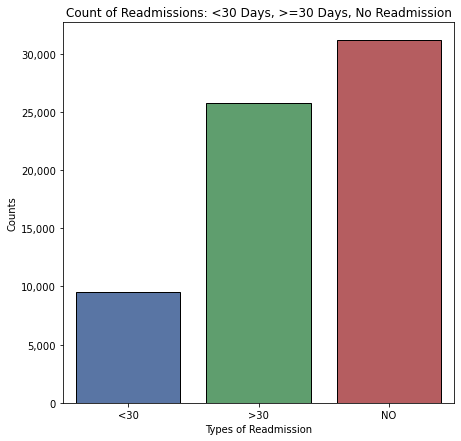

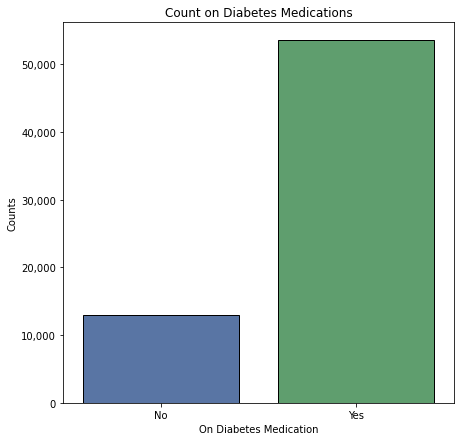

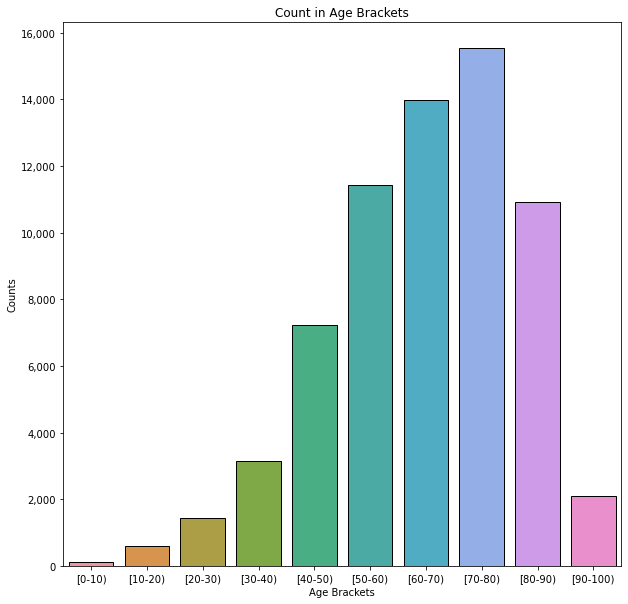

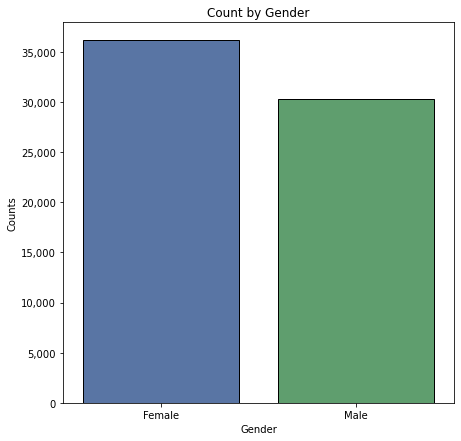

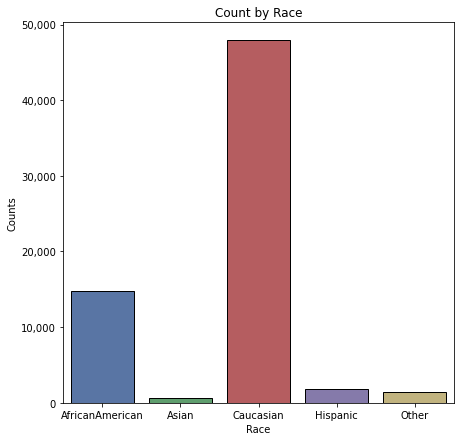

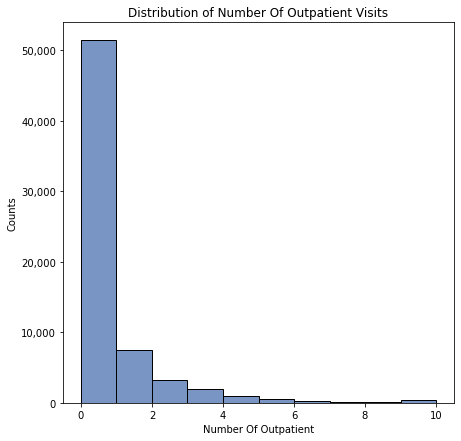

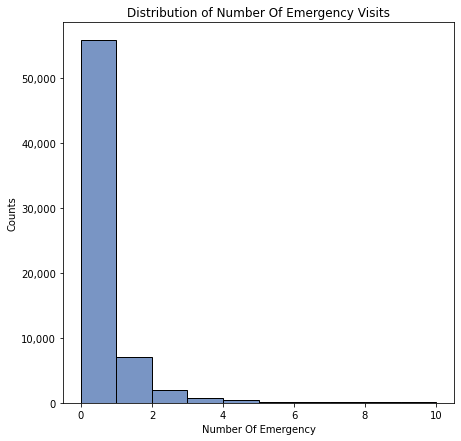

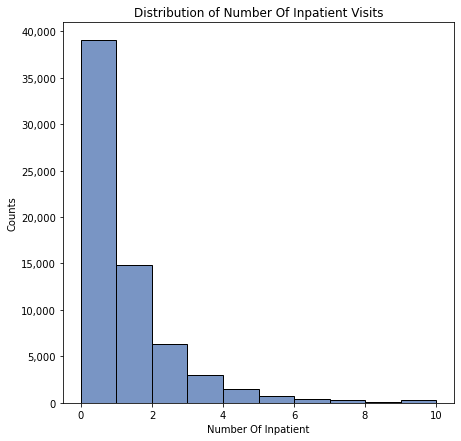

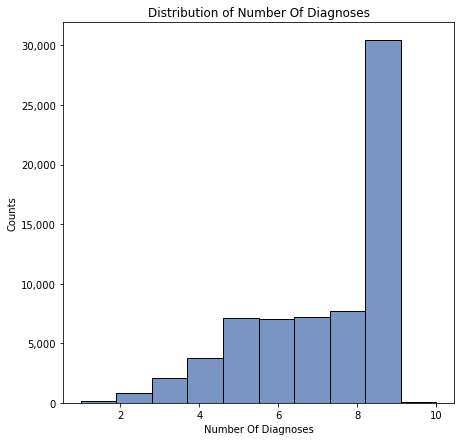

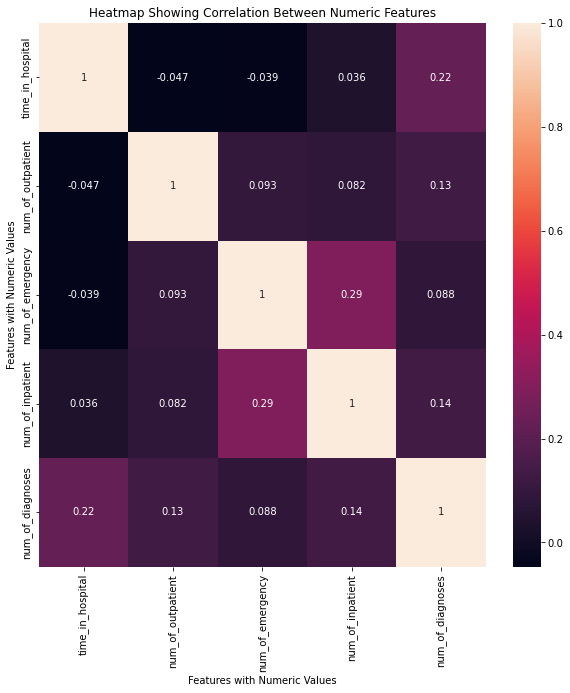

In [72]:
# Creating the key univariate plots on features
# create_plot function accepts the following parameters and generates a specific type of plot
#(xAxis-Data, yAxis-Data, xAxis-Label,yAxis-Label,Title of Plot, Plot type, Override default figsize)

# Create a number of Boxplots
create_plots('A1Cresult','time_in_hospital','A1C Result',
             'Length of Stay in Days',
             'Result of >7 or >8 Indicates High Levels of Blood Glucose Over The Past Three Months','Boxplot')
print("Patients with A1C greater than 7 are showing up in the higher\nLength of Stay, higher A1C may require longer hospitalizations\n")

create_plots('max_glu_serum','time_in_hospital',
             'Blood Glucose Level','Length of Stay in Days',
             'Glucose Serum of >200 or >300 Is High Health Risk','Boxplot')
print("Patients with blood glucose higher than 200 are also showing higher\nLength of Stay")

# Create a number of Barplots
create_plots('readmitted','discharge_group',
             'Types of Readmission','Counts',
             'Count of Readmissions: <30 Days, >=30 Days, No Readmission',
             'Barplot')

create_plots('diabetesMed','discharge_group',
             'On Diabetes Medication','Counts',
             'Count on Diabetes Medications','Barplot')

create_plots('age','discharge_group',
             'Age Brackets','Counts','Count in Age Brackets','Barplot',10)

create_plots('gender','discharge_group',
             'Gender','Counts','Count by Gender','Barplot')

create_plots('race','discharge_group',
             'Race','Counts','Count by Race','Barplot')

# Create a number of Histplots
histplot_features_list = ['num_of_outpatient',
                          'num_of_emergency','num_of_inpatient']
for plot in histplot_features_list:
    plotLbl = plot.replace("num_of_","number of ")
    plotLbl = plotLbl.title()
    create_plots(plot,'blank',
                 plotLbl,'Counts',
                 'Distribution of ' + plotLbl + ' Visits','Histplot')

histplot_features_list = ['num_of_diagnoses']
for plot in histplot_features_list:
    plotLbl = plot.replace("num_of_","number of ")
    plotLbl = plotLbl.title()
    create_plots(plot,'blank',
                 plotLbl,'Counts',
                 'Distribution of ' + plotLbl ,'Histplot')


# Create Heatmap to show correlation
create_plots('Features with Numeric Values',
             'Features with Numeric Values',
             'Features with Numeric Values',
             'Features with Numeric Values',
             'Heatmap Showing Correlation Between Numeric Features',
             'Heatmap',10)

<h1>Start of Citation and References Section</h1>

1) Source of data is UCI Machine Learning Repository, URL is: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

2) The data is provided by the Virigina Commonwealth University, on Diabetes related admission from 130-US hospitals for years 1999 through 2008.

3) Target is predicting classifying admissions as re-admit; less than 30, more than 30 or none. 

4) This is a classification problem.

5) Data has 50 columns and 6) 100,000 rows of data

7) Dataset has a lot of columns, it is going to test my healthcare background. One of the reasons why I choose this dataset, I have done a lot of work on clinical outcomes.

# Citations:


1. List of features and descriptions: https://www.hindawi.com/journals/bmri/2014/781670/tab1/
2. Open Access article: https://www.hindawi.com/journals/bmri/2014/781670/
3. Citation: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records", BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670